In [5]:
import shapely
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from shapely.geometry import Point
from scipy.constants import epsilon_0, speed_of_light
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio
from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains


In [11]:
import shapely
from meshwell.prism import Prism
from meshwell.model import Model
from meshwell.gmsh_entity import GMSH_entity
from skfem.visuals.matplotlib import draw_mesh3d
from skfem.io.meshio import from_meshio
import meshio


def fiber_mesh(outer_radius_core =  700 / 2,
                outer_radius_clad = 850 / 2,
                outer_radius_air = 2500 / 2,
                clad_resolution = 100,
                clad_dropoff = 200,
                air_resolution = 200,
                ):
    """Returns a mesh of the air-core fiber.
    Constructs a mesh for a fiber with specified parameters for the core,
    cladding, and surrounding air. The mesh is created using the GMSH
    geometry kernel and is suitable for finite element analysis.

    Parameters
    ----------
    outer_radius_core : float
        The outer radius of the fiber core.
    outer_radius_clad : float
        The outer radius of the fiber cladding.
    outer_radius_air : float
        The outer radius of the surrounding air.
    clad_resolution : float
        The mesh resolution for the high-index cladding.
    clad_dropoff : float
        The mesh size drop-off rate around the cladding.
    air_resolution : float
        The mesh resolution for the surrounding air.

    Returns
    -------
    mesh : skfem.Mesh
        The generated mesh object.
    """
    
    model = Model()

    core = GMSH_entity(
        gmsh_function=model.occ.addDisk,
        gmsh_function_kwargs={"xc": 0, "yc": 0, "zc": 0, "rx": outer_radius_core, "ry": outer_radius_core},
        model=model,
        mesh_order=1,
        physical_name="core",
        dimension=2,
    )

    clad = GMSH_entity(
        gmsh_function=model.occ.addDisk,
        gmsh_function_kwargs={"xc": 0, "yc": 0, "zc": 0, "rx": outer_radius_clad, "ry": outer_radius_clad},
        model=model,
        mesh_order=2,
        physical_name="clad",
        dimension=2,
        resolution={"resolution": clad_resolution, "DistMax": clad_dropoff, "SizeMax": air_resolution},
    )

    air = GMSH_entity(
        gmsh_function=model.occ.addDisk,
        gmsh_function_kwargs={"xc": 0, "yc": 0, "zc": 0, "rx": outer_radius_air, "ry": outer_radius_air},
        model=model,
        mesh_order=3,
        physical_name="air",
        dimension=2,
    )

    return from_meshio(
        model.mesh(
            entities_list=[core, clad, air],
            filename="mesh.msh",
            default_characteristic_length=air_resolution,
        )
    )

  0%|          | 0/3 [00:00<?, ?it/s]

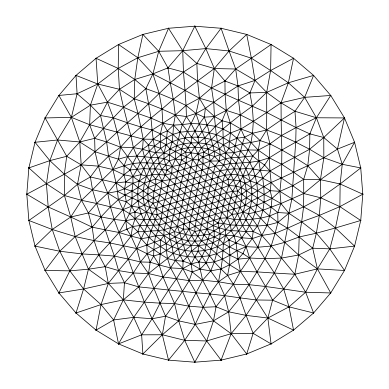

In [13]:
mesh = fiber_mesh(outer_radius_core =  700 / 2,
                outer_radius_clad = 850 / 2,
                outer_radius_air = 2500 / 2,
                clad_resolution = 200,
                clad_dropoff = 200,
                air_resolution = 200
                )
mesh.draw().show()

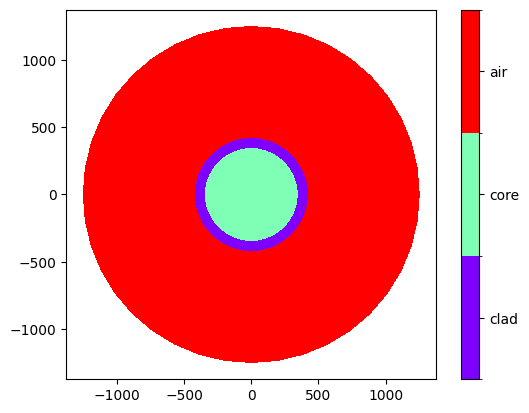

In [15]:
plot_domains(mesh)
plt.show()

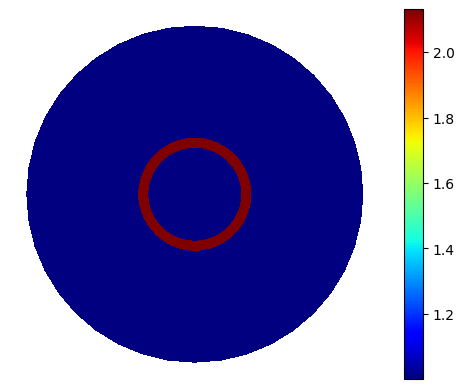

In [16]:
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
for subdomain, n in {"core": 1.0002, "clad": 1.46, "air": 1.0002}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

In [17]:
wavelength = 0.635
modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=2, order=2)
for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.4f}")
    mode.show(mode.E.real, colorbar=True, direction="x")
    mode.show(mode.E.imag, colorbar=True, direction="x")